# Image Search Based on a Natural Language Query Using CLIP Model

In this notebook, we implement a simople image search solution based on a natural language query using the CLIP model [1]. We use CLIP to pre-calculate embeddigns for images in a collection. For a given query, we calculate its embedding using CLIP and then search for the nearest neighbors in the collection of image embeddigns. 

The implementation is based on [2].

### References
  1. https://openai.com/blog/clip/#rf33
  2. https://github.com/haltakov/natural-language-image-search
  
### Data
We use a small image collection available in the `tensorhouse-data` repository (`tensor-house-data/search/unspash-small`).

## Load the CLIP Model

In [1]:

import clip
import torch
import math
import numpy as np
import pandas as pd

from PIL import Image
import shutil
import os

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from mpl_toolkits.axes_grid1 import ImageGrid

## Load CLIP Model

In [2]:
#
# Load the open CLIP model
#
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████| 353976522/353976522 [00:12<00:00, 27375041.23it/s]


## Process Input Images and Save Features

Images found: 759


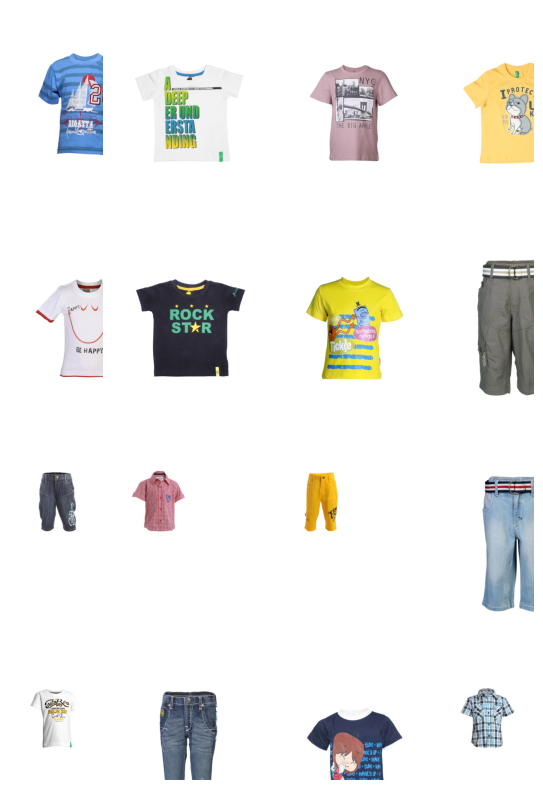

In [3]:
from pathlib import Path

# Set the path to the images
images_path = Path('Apparel/Boys/Images/images_with_product_ids')

# List all JPGs in the folder
images_files = list(images_path.glob('*.jpg'))

# Print some statistics
print(f'Images found: {len(images_files)}')

# Display images
rows, columns = (4, 4)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(rows, columns),  
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, images_files[:rows*columns]):
    ax.imshow(Image.open(im))
    ax.axis('off')
plt.show()

In [4]:
!pip install pinecone-client

In [5]:
import pinecone

pinecone.init(api_key = "3f502bca-9e91-41e3-9a4a-81b2570dc419", environment="gcp-starter")

#pinecone.create_index("vectors", dimension=512, metric="euclidean")
pinecone.describe_index("vectors")

IndexDescription(name='vectors', metric='euclidean', replicas=1, dimension=512.0, shards=1, pods=1, pod_type='starter', status={'ready': True, 'state': 'Ready'}, metadata_config=None, source_collection='')

In [6]:
#
# Path where the feature vectors will be stored
#
index = pinecone.Index("vectors")

features_path = Path(".") / "features"
if os.path.exists(features_path):
    shutil.rmtree(features_path)
os.makedirs(features_path)

# Function that computes the feature vectors for a batch of images
def compute_clip_features(images_batch):
    # Load all the images from the files
    images = [Image.open(image_file) for image_file in images_batch]
    
    # Preprocess all images
    images_preprocessed = torch.stack([preprocess(image) for image in images]).to(device)

    with torch.no_grad():
        # Encode the images batch to compute the feature vectors and normalize them
        images_features = model.encode_image(images_preprocessed)
        images_features /= images_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return images_features.cpu().numpy()

# Define the batch size
batch_size = 16

# Compute how many batches are needed
batches = math.ceil(len(images_files) / batch_size)

#
# Process each batch
#
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the images for the current batch
            batch_files = images_files[i*batch_size : (i+1)*batch_size]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            print(batch_features[0].shape)
            print(batch_features[0])
            print(type(batch_features))
            np.save(batch_features_path, batch_features)

            # Save the image IDs to a CSV file
            image_ids = [image_file.name.split(".")[0] for image_file in batch_files]
            image_ids_data = pd.DataFrame(image_ids, columns=['image_id'])
            image_ids_data.to_csv(batch_ids_path, index=False)

            for i in range(batch_features.shape[0]):
                index.upsert(
                    vectors = [
                        {
                            'id': image_ids[i],
                            'values': batch_features[i].tolist()
                        }
                    ]
                )
            
        except Exception as e:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i} {e}')

Processing batch 1/48
(512,)
[-1.22324396e-02  1.91065092e-02 -3.86044867e-02  1.37319798e-02
  1.80953685e-02 -2.23196205e-02  5.50385751e-02  4.30231057e-02
  3.11069842e-02  3.21879014e-02  3.06381267e-02  2.88563054e-02
  2.22241916e-02 -9.09246597e-03 -5.26117533e-03 -3.16273421e-03
  4.71283235e-02  3.50579806e-02  3.12211066e-02 -1.84628274e-02
 -7.93913454e-02 -1.30217383e-02  3.18671241e-02 -5.63553125e-02
 -2.10862830e-02  1.96389221e-02 -5.71324630e-03 -1.05763162e-02
 -2.09509078e-02 -2.21000873e-02  2.73592621e-02  4.95528430e-02
  8.15439131e-03 -5.17913001e-03 -3.30300406e-02 -8.81731883e-03
 -3.99525613e-02  6.94733188e-02 -1.93252787e-02 -3.87234701e-04
 -2.43404545e-02 -7.59224175e-03  1.60276964e-02 -1.41101796e-02
 -1.78066269e-02 -4.34849299e-02  2.89032906e-02  3.21164494e-03
  2.80781034e-02 -3.73731069e-02  5.16230017e-02 -4.00171470e-04
 -3.99324950e-03 -2.73326598e-02 -3.01868003e-02  2.79209130e-02
  1.97690669e-02 -3.42053082e-03 -2.86303870e-02  1.81709509e

In [7]:
# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the image IDs
image_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
image_ids.to_csv(features_path / "image_ids.csv", index=False)

## Load Features

In [8]:
# Load the image IDs
image_ids = pd.read_csv(features_path / 'image_ids.csv')
image_ids = list(image_ids['image_id'])

# Load the features vectors
image_features = np.load(features_path / 'features.npy')

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
    image_features = torch.from_numpy(image_features).float().to(device)
else:
    image_features = torch.from_numpy(image_features).to(device)

# Print some statistics
print(f"Images loaded: {len(image_ids)}")

Images loaded: 759


## Search Images Based on a Text Query 

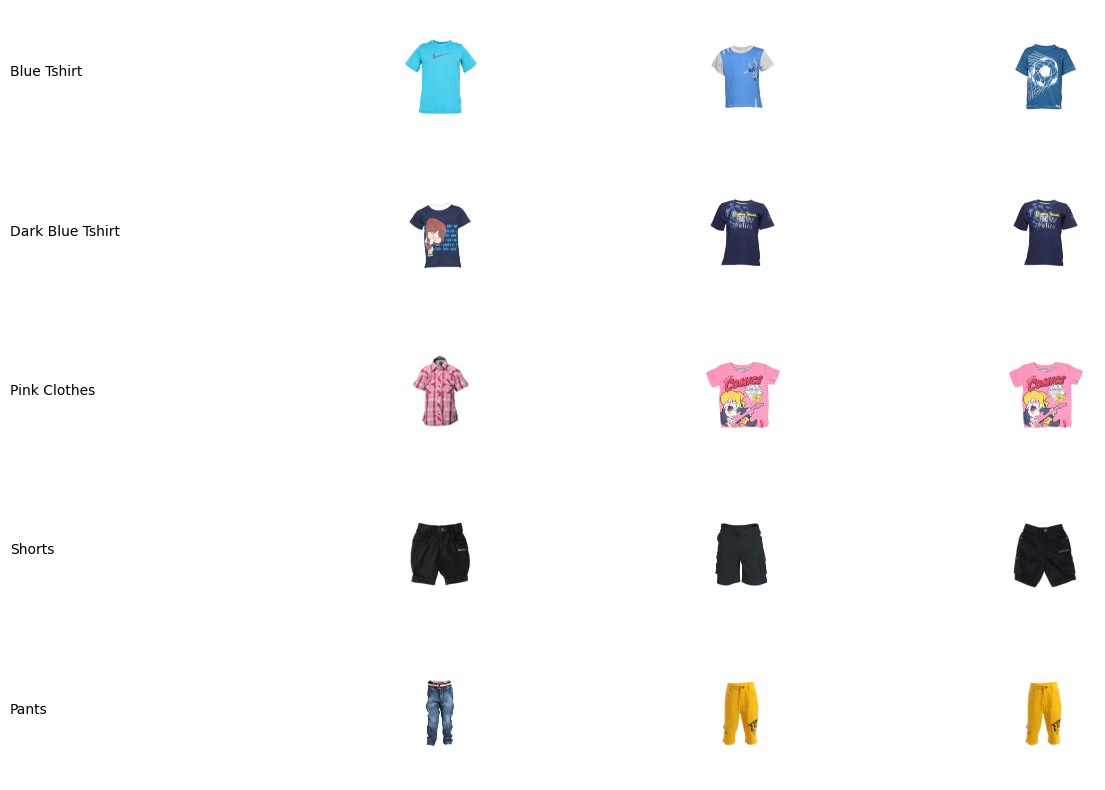

In [9]:
def encode_search_query(search_query):
    with torch.no_grad():
        # Encode and normalize the search query using CLIP
        text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
        text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

    # Retrieve the feature vector
    return text_encoded

def find_best_matches(text_features, image_features, image_ids, results_count=3):
  # Compute the similarity between the search query and each image using the Cosine similarity
  similarities = (image_features @ text_features.T).squeeze(1)

  # Sort the images by their similarity score
  best_image_idx = (-similarities).argsort()

  # Return the image IDs of the best matches
  return [image_ids[i] for i in best_image_idx[:results_count]]

def search(search_query, image_features, image_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  return find_best_matches(text_features, image_features, image_ids, results_count)

#
# Search for images and visualize the results
#
search_queries = ['Blue Tshirt', 
                  'Dark Blue Tshirt', 
                  'Pink Clothes', 
                  'Shorts',
                  'Pants'
                ]
n_results_per_query = 3
 
fig, ax = plt.subplots(len(search_queries), n_results_per_query + 1, figsize=(15, 10))    
for i, search_query in enumerate(search_queries):
    result_image_ids = search(search_query, image_features, image_ids, n_results_per_query)
    
    ax[i, 0].text(0.0, 0.5, search_query)
    ax[i, 0].axis('off')
    for j, image_id in enumerate(result_image_ids):
        image = Image.open(f'{images_path}/{image_id}.jpg')
        ax[i, j+1].imshow(image)
        ax[i, j+1].axis('off')